# Dataset curation for time series

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/edgeimpulse/course-embedded-ml-capstone/blob/master/02-feature-scaling/time_series_dataset_curation.ipynb)

In the paper "Efficient BackProp" [1], LeCun et al. shows that we can achieve a more accurate model (e.g. artificial neural network) in less time by standarizing (i.e. to a mean of 0 and unit variance) and decorrelating our input data.

However, the process of standarization assumes that the data is normally distributed (i.e. Gaussian). If our data does not follow a Gaussian distribution, we should perform normalization [2], where we divide by the range to produce a set of values between 0 and 1.

Create a directory */content/dataset* and upload your entire dataset there. Run through the cells in this notebook, following all of the directions to analyze the data and create a curated dataset. Note that we perform only standardization in this notebook.

The standardized data will be stored in the */content/out* directory and zipped to */content/out.zip* for easy downloading.

Author: EdgeImpulse, Inc.<br>
Date: July 28, 2022<br>
License: Apache-2.0<br>

[1] http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf

[2] https://becominghuman.ai/what-does-feature-scaling-mean-when-to-normalize-data-and-when-to-standardize-data-c3de654405ed

## Step 1: Read data from CSV files

Read each CSV, verify that the data (and header) are valid, save the data in Numpy format, and save the associated filename in a list.

In [113]:
import csv
import os
import shutil
import random

import numpy as np
import matplotlib.pyplot as plt

In [114]:
### Settings

# Path information
HOME_PATH = "/content"              # Location of the working directory
DATASET_PATH = "/content/ATC"   # Upload your .csv samples to this directory
OUT_PATH = "/content/ATC"           # Where output files go (will be deleted and recreated)
TRAIN_DIR = "training"              # Where to store training output files
TEST_DIR = "testing"                # Where to store testing output files
OUT_ZIP = "/content/ATC"        # Where to store the zipped output files

# Set aside 20% for test
TEST_RATIO = 0.2

# Seed for pseudorandomness
SEED = 42

In [115]:
### Read in .csv files to construct our data in a numpy array

X_all = []
filenames = []
first_sample = True
channel_names = None
sample_shape = None

# Loop through all files in our dataset
for filename in os.listdir(DATASET_PATH):

  # Check if the path is a file
  filepath = os.path.join(DATASET_PATH, filename)
  if not os.path.isfile(filepath):
    continue

  # Read CSV file
  data = np.genfromtxt(filepath,
                      dtype=float,
                      delimiter=',',
                      names=True)

  # Get length of the sample
  num_readings = data.shape[0]

  # Extract sample rate (in milliseconds), header (without timestamp), and shape info (without
  # timestamp) from the first sample we read
  if first_sample:
    channel_names = data.dtype.names
    sample_shape = (num_readings, len(channel_names))
    first_sample = False

  # Check to make sure the new sample conforms to the first sample
  else:

    # Check header
    if data.dtype.names != channel_names:
      print("Header does not match. Skipping", filename)
      continue

    # Check shape
    if (num_readings, len(channel_names)) != sample_shape:
      print("Shape does not match. Skipping", filename)
      continue

  # Create sample (drop timestamp column)
  sample = np.zeros(sample_shape)
  for i in range(num_readings):
    sample[i, :] = np.array(data[i].item())

  # Append to our dataset
  X_all.append(sample)

  # Append the filename to our list of filenames
  filenames.append(filename)

# Convert the dataset into a numpy array
X_all = np.array(X_all)

# Get number of samples and channels
num_samples = X_all.shape[0]
num_channels = len(channel_names)

print("Header:", channel_names)
print("Dataset shape:", X_all.shape)
print("Number of samples:", num_samples)
print("Number of files", len(filenames))

Header: ('timestamp', 'accX', 'accY', 'accZ', 'temperature', 'current')
Dataset shape: (50, 200, 6)
Number of samples: 50
Number of files 50


## Step 2: Split the data

We should not include the test set in our analysis or scaling efforts, as that could introduce a bias.

In [116]:
### Shuffle and split dataset

# Use a seed in case we want to recreate the exact results
random.seed(SEED)

# Shuffle our dataset
X_y = list(zip(X_all, filenames))
random.shuffle(X_y)
X_all, filenames = zip(*X_y)

# Calculate number of validation and test samples to put aside (round down)
num_samples_test = int(TEST_RATIO * num_samples)

# The first `num_samples_test` samples of the shuffled list becomes the test set
X_test = X_all[:num_samples_test]
filenames_test = filenames[:num_samples_test]

# The remaining samples become the training set
X_train = X_all[num_samples_test:]
filenames_train = filenames[num_samples_test:]

# Convert data to Numpy arrays
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

# Print shapes of our sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (40, 200, 6)
X_test shape: (10, 200, 6)


## Step 3: Analyze the training data

Look at the histograms to determine if scaling is required

In [117]:
### Reshape the data (drop timestamp column)
def flatten_data_for_analysis(X, num_channels):

  # Calculate number of rows in each channel (channel = different sensor reading)
  num_rows = X.shape[0] * X_train.shape[1]

  # Combine all data in each channel
  X_flatten = np.reshape(X, (num_rows, num_channels))

  # Drop the timestamp column--it will mess up our analysis
  X_flatten = np.delete(X_flatten, 0, axis=1)

  return X_flatten

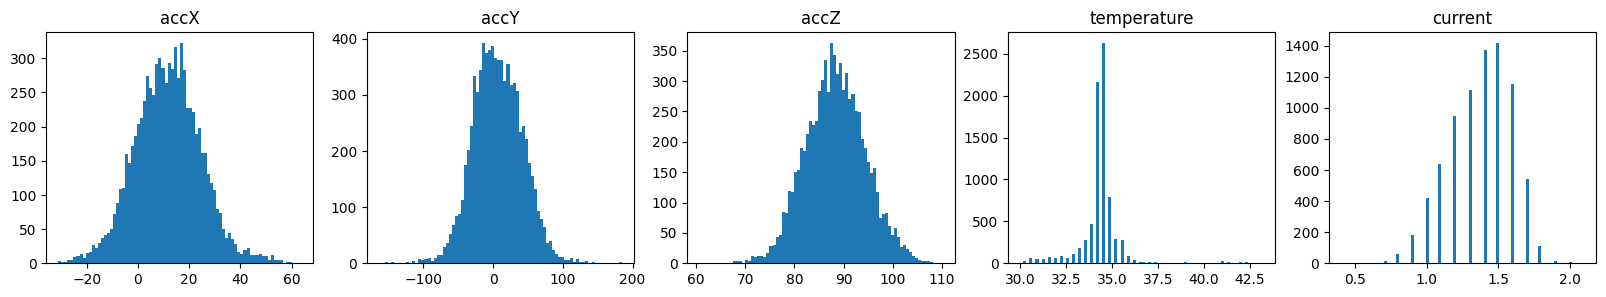

In [118]:
### Examine the histograms of all the data

# Settings
num_bins = 80

# Flatten the data along each channel
X_train_flatten = flatten_data_for_analysis(X_train, num_channels)
channel_names_no_timestamp = channel_names[1:]

# Create subplots
num_hists = len(channel_names_no_timestamp)
fig, axs = plt.subplots(1, num_hists, figsize=(20,3))

# Create histogram for each category of data
for i in range(num_hists):
  _ = axs[i].hist(X_train_flatten[:, i],
                  bins=num_bins)
  axs[i].title.set_text(channel_names_no_timestamp[i])

This look like fairly well-behaved data with Gaussian distributions. However, look at the X-axis range (the min and max values that each channel contains in our data).

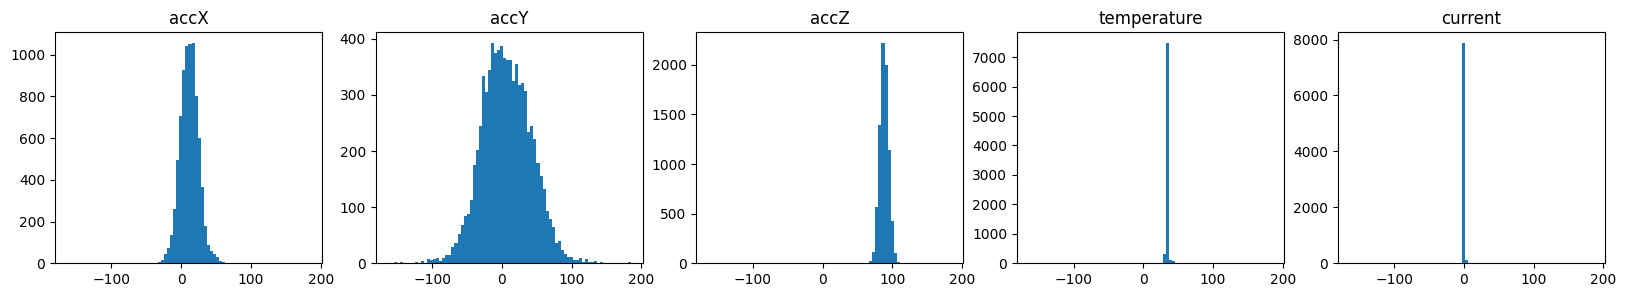

In [119]:
### Try the histograms with the same scale

# Get the minimum and maximum values (the range)
min_val = X_train_flatten.min()
max_val = X_train_flatten.max()

# Create subplots
num_hists = len(channel_names_no_timestamp)
fig, axs = plt.subplots(1, num_hists, figsize=(20,3))

# Create histogram for each category of data
for i in range(num_hists):
  _ = axs[i].hist(X_train_flatten[:, i],
                  bins=num_bins,
                  range=(min_val, max_val))
  axs[i].title.set_text(channel_names_no_timestamp[i])

Whoa! If we graph using the same range, it looks like there's a lot more variance in our gyroscope data. However, that's simply becuase the gyroscope uses different units (and therefore has a different range of values) than our accelerometer. To fix this, we should standardize our data.

## Step 4: Standardize the data

Perform standarization so that our data, per-channel, has a mean of 0 and a standard deviation of 1.

In [120]:
### Function to calculate dataset metrics (mean, std dev, etc.) for each channel
def calc_metrics(X, ignore_first_col=False):

  # Flatten along the channels
  num_rows = X.shape[0] * X.shape[1]
  X_flatten = np.reshape(X, (num_rows, num_channels))

  # Calculate means, standard deviations, and ranges
  means = np.mean(X_flatten, axis=0)
  std_devs = np.std(X_flatten, axis=0)
  mins = np.min(X_flatten, axis=0)
  ranges = np.ptp(X_flatten, axis=0)

  # Drop the first column if requested
  if ignore_first_col:
    return (means[1:], std_devs[1:], mins[1:], ranges[1:])
  else:
    return (means, std_devs, mins, ranges)

In [121]:
### Function to perform standardization for a given set of data
def standardize_data(a, mean, std_dev):
  standardized_a = (a - mean) / std_dev
  return standardized_a

In [122]:
### Compute the metrics of the training data

# Compute metrics (drop timestamp column)
(means, std_devs, mins, ranges) = calc_metrics(X_train, ignore_first_col=True)

# Print out the results (drop timestamp column)
print(channel_names[1:])
print("Means:", [float("{:.4f}".format(x)) for x in means])
print("Std devs:", [float("{:.4f}".format(x)) for x in std_devs])
print("Mins:", [float("{:.4f}".format(x)) for x in mins])
print("Ranges:", [float("{:.4f}".format(x)) for x in ranges])

('accX', 'accY', 'accZ', 'temperature', 'current')
Means: [11.7505, 6.5878, 88.3374, 34.3782, 1.3741]
Std devs: [12.9688, 35.3369, 6.1038, 1.2336, 0.2179]
Mins: [-31.06, -163.77, 60.72, 30.0, 0.4]
Ranges: [94.74, 348.43, 49.44, 13.23, 1.7]


**Record these values!** We will need them to perform preprocessing on the test dataset and for preprocessing raw data we capture during live inference (deployment).

In [123]:
### Standardize each channel (do NOT standardize the timestamp channel!)

# Initialize standardized data arrays
X_train_std = np.zeros(X_train.shape)
X_test_std = np.zeros(X_test.shape)

# Go through each channel in the training data
for i in range(len(channel_names)):

  # Skip the timestamp channel!
  if i == 0:
    X_train_std[:,:,i] = X_train[:,:,i]

  # Otherwise, perform standardization
  else:
    X_train_std[:,:,i] = standardize_data(X_train[:,:,i],
                                          means[i - 1],
                                          std_devs[i - 1])

# Go through each channel in the test data. Notice that we use the same means
# and standard deviations that we calculated from the training data!
for i in range(len(channel_names)):

  # Skip the timestamp channel!
  if i == 0:
    X_test_std[:,:,i] = X_test[:,:,i]

  # Otherwise, perform standardization
  else:
    X_test_std[:,:,i] = standardize_data(X_test[:,:,i],
                                          means[i - 1],
                                          std_devs[i - 1])

# Print shapes
print("X_train_std shape:", X_train_std.shape)
print("X_test_std shape:", X_test_std.shape)

X_train_std shape: (40, 200, 6)
X_test_std shape: (10, 200, 6)


('accX', 'accY', 'accZ', 'temperature', 'current')
Means: [-0.0, 0.0, 0.0, 0.0, -0.0]
Std devs: [1.0, 1.0, 1.0, 1.0, 1.0]
Mins: [-3.301, -4.821, -4.5246, -3.549, -4.4698]
Ranges: [7.3052, 9.8602, 8.0999, 10.7244, 7.8011]


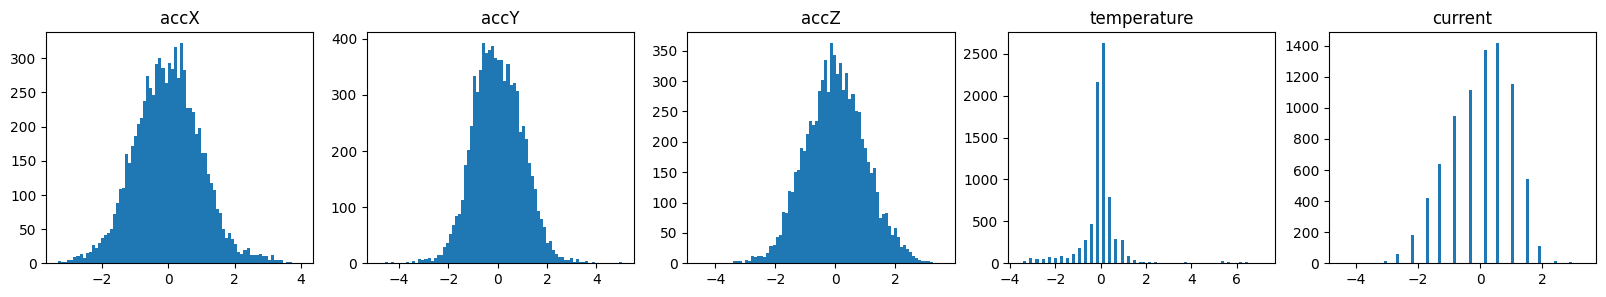

In [124]:
### Examine the metrics and histograms of the newly standardized data

# Compute metrics for the standardized data
(means, std_devs, mins, ranges) = calc_metrics(X_train_std,
                                               ignore_first_col=True)
print(channel_names[1:])
print("Means:", [float("{:.4f}".format(x)) for x in means])
print("Std devs:", [float("{:.4f}".format(x)) for x in std_devs])
print("Mins:", [float("{:.4f}".format(x)) for x in mins])
print("Ranges:", [float("{:.4f}".format(x)) for x in ranges])

# Flatten the data along each channel
X_train_flatten = flatten_data_for_analysis(X_train_std, num_channels)
channel_names_no_timestamp = channel_names[1:]

# Create subplots
num_hists = len(channel_names_no_timestamp)
fig, axs = plt.subplots(1, num_hists, figsize=(20,3))

# Create histogram for each category of data
for i in range(num_hists):
  _ = axs[i].hist(X_train_flatten[:, i],
                  bins=num_bins)
  axs[i].title.set_text(channel_names_no_timestamp[i])

Check the metrics and histograms above. All means should be 0.0 and all standard deviations should be 1.0. Do the ranges seem more reasonable?

## Steap 5: Store preprocessed data in CSV files

In [125]:
### Function to write header and data to CSV files to given directory
def write_csv_data(header, data, filenames, dir_path):

  # Go through each filename - should be in the same order as our samples in X
  for i, filename in enumerate(filenames):

    # Write header and data (for that one sample) to the CSV file
    file_path = os.path.join(dir_path, filename)
    with open(file_path, 'w') as f:
      csv_writer = csv.writer(f, delimiter=',')
      csv_writer.writerow(header)
      csv_writer.writerows(data[i])

In [126]:
### Delete output directory (if it exists) and recreate it
if os.path.exists(OUT_PATH):
  shutil.rmtree(OUT_PATH)
os.makedirs(os.path.join(OUT_PATH, TRAIN_DIR))
os.makedirs(os.path.join(OUT_PATH, TEST_DIR))

In [127]:
### Write training and test data to .csv files in separate directories

# Write out training data
dir_path = os.path.join(OUT_PATH, TRAIN_DIR)
write_csv_data(channel_names, X_train_std, filenames_train, dir_path)

# Write out test data
dir_path = os.path.join(OUT_PATH, TEST_DIR)
write_csv_data(channel_names, X_test_std, filenames_test, dir_path)

In [128]:
### Zip output directory
%cd {OUT_PATH}
!zip -FS -r -q {OUT_ZIP} *
%cd {HOME_PATH}

/content/ATC
/content
